Welcome to the first handson!!!
- In this handson you will be building an deep neural network network by integrating batch normalization
- You will also be implementing minibatch gradient and L2 regularization to train you network
- Follow the instruction provided for cell to write the code in each cell.
- Run the below cell for to import necessary packages to read and visualize data
- Before submit your notebook. Restart the kernel and run all the cell. Make sure that any cell shouldn't cause any error or problem.
- Don't forget to run the last cell in the jupyter notebook, failing which your efforts will be invalid.
- Don't delete any cell given in the notebook.

In [19]:
import pandas as pd
import numpy as np
from test_opthyptuning_batchnorm import batchnorm
import matplotlib.pyplot as plt
import matplotlib.colors

The data is provided as file named 'data.csv'.  
Using pandas read the csv file and assign the resulting dataframe to variable 'data'   
for example if file name is 'xyz.csv' read file as **pd.read_csv('xyz.csv')** 

In [20]:
###Start code here
data =pd.read_csv('data.csv')
###End code here
data.head()

,feature1,feature2,target
0,-0.260842,0.965382,0.0
1,0.880000,0.000000,1.0
2,-0.942991,-0.332820,0.0
3,0.309017,0.951057,0.0
4,-0.691934,-0.543716,1.0


- Extract feature1 and feature2 values from dataframe 'df' and assign it to variable 'X'
- Extract target variable 'traget' and assign it to variable 'y'.  
Hint:
 - Use .values to exract values from dataframe

In [21]:
X = data.loc[:, data.columns != 'target'].values
y = data['target'].values

- Run the below cell to visualize the data in x-y plane. (visualization code has been written for you)
- The green spots corresponds to target value 0 and blue spots corresponds to target value 1

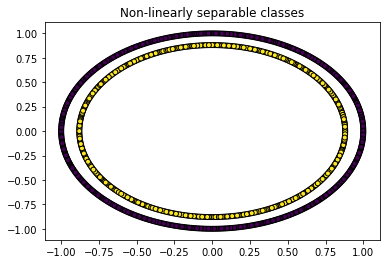

In [22]:
colors=['green','blue']
cmap = matplotlib.colors.ListedColormap(colors)
#Plot the figure
plt.figure()
plt.title('Non-linearly separable classes')
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')
plt.show()

- In order to feed the network the input has to be of **shape (number of features, number of samples)** and target should be of shape **(1, number of samples)**
- Transpose X and assign it to variable 'X_data'
- reshape y to have shape (1, number of samples) and assign to variable 'y_data'

In [23]:
###Start code here
X_data =  X.T
y_data = y.reshape(1, -1)
###End code here

assert X_data.shape == (2, 1000)
assert y_data.shape == (1, 1000)

Define the network dimension to have **two** input features, **four** **hidden layers** with **20** nodes each, one output node at final layer. 

In [24]:
###Start code here
layer_dims = [2, 20, 20, 20, 20, 1]
###End code here

Import tensorflow as tf

In [25]:
import tensorflow as tf            #import tensorflow

Define a function named placeholders to return two placeholders one for input data as A_0 and one for output data as Y.
- Set the datatype of placeholders as **float32**
- parameters - num_features
- Returns - A_0 with shape (num_feature, None) and Y with shape(1,None)

In [26]:
def placeholders(num_features):
    ###Start code here
    A_0 = tf.placeholder( shape=([num_features, None]), dtype=tf.float32)
    Y = tf.placeholder(shape=([1,None]), dtype=tf.float32)
    ###End code
    return A_0,Y

define function named initialize_parameters_deep() to initialize weights and bias for each layer
- Use tf.get_variable to initialise weights and bias, set datatype as **float32**
- Make sure you are using xavier initialization for weigths and initialize bias to zeros
- Parameters - layer_dims
- Returns - dictionary of weights and bias

In [27]:
def initialize_parameters_deep(layer_dims):
    tf.set_random_seed(1)
    L = len(layer_dims)
    parameters = {}
    for l in range(1,L):
        ###Start code here
        parameters['W' + str(l)] = tf.get_variable('W'+ str(l), shape=([layer_dims[l], layer_dims[l-1]]), dtype=tf.float32,
                                                  initializer=tf.contrib.layers.xavier_initializer())
        parameters['b' + str(l)] = tf.get_variable('b'+ str(l), shape=([layer_dims[l], 1]), dtype=tf.float32, initializer=tf.zeros_initializer())
        
        ###End code
    return parameters 

Define functon named linear_forward_prop() to define forward propagation for a given layer.
- parameters: A_prev(output from previous layer), W(weigth matrix of current layer), b(bias vector for current layer),activation(type of activation to be used for out of current layer)  
- returns: A(output from the current layer)
- Use relu activation for hidden layers and for final output layer return the output unactivated i.e if activation is sigmoid
- After computing linear output Z implement batch normalization before feeding to activation function, **set traing = True and axis = 0**

In [28]:
def linear_forward_prop(A_prev,W,b, activation):
    ###Start code here
    Z = tf.add(tf.matmul( W, A_prev), b)                          
    #call linear_fowrward prop
    Z = tf.layers.batch_normalization(inputs=Z, axis=0, training=True, gamma_initializer=tf.ones_initializer(), 
                                      beta_initializer=tf.zeros_initializer())                             
    #implement batch normalization on Z
    
    if activation == "sigmoid":
        A = Z
    elif activation == "relu":
        A = tf.nn.relu(Z)
    return A

Define forward propagation for entire network as l_layer_forward()
- Parameters: A_0(input data), parameters(dictionary of weights and bias)
- returns: A(output from final layer)  

In [29]:
def l_layer_forwardProp(A_0, parameters):
    A = A_0
    L = len(parameters)//2
    for l in range(1,L):
        A_prev = A
    
        A = linear_forward_prop(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation='relu' )                 
        #call linear forward prop with relu activation
    A = linear_forward_prop(A, parameters['W' +str(L)], parameters['b' + str(L)], activation='sigmoid')                      
    #call linear forward prop with sigmoid activation
    
    return A

- Define the cost function
- parameters:
  - Z_final: output fro final layer
  - Y: actual output
  - parameters: dictionary of weigths and bias
  - regularization : boolean
  - lambd: regularization parameter
- First define the original cost using tensoflow's sigmoid_cross_entropy function
- If **regularization == True** add regularization term to original cost function

In [30]:
def final_cost(Z_final, Y , parameters, regularization = False, lambd = 0):
    cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=Z_final,labels=Y)
    if regularization:
        reg_term = 0
        L = len(parameters)//2
        for l in range(1,L+1):
            
            reg_term += tf.nn.l2_loss(parameters['W'+str(l)])             #add L2 loss term
            
        cost = cost + (lambd/2) * reg_term
    return tf.reduce_mean(cost)

Define the function to generate mini-batches. **Important: Use np.random.permutation for generate random indicies**

In [31]:
import numpy as np
def random_samples_minibatch(X, Y, batch_size, seed = 1):
    np.random.seed(seed)
    
    m = X.shape[1]                                         #number of samples
    num_batches =int( m / batch_size)                                 #number of batches derived from batch_size
    
    indices = np.random.permutation(m)                                  # generate ramdom indicies
    shuffle_X = X[:,indices]
    shuffle_Y = Y[:,indices]
    mini_batches = []
    
    #generate minibatch
    for i in range(num_batches):
        X_batch = shuffle_X[ :, i * batch_size:(i+1) * batch_size]
        Y_batch = shuffle_Y[ :, i * batch_size:(i+1) * batch_size]
        
        assert X_batch.shape == (X.shape[0], batch_size)
        assert Y_batch.shape == (Y.shape[0], batch_size)
        
        mini_batches.append((X_batch, Y_batch))
    
    #generate batch with remaining number of samples
    if m % batch_size != 0:
        X_batch = shuffle_X[ :, (num_batches * batch_size): ]
        Y_batch = shuffle_Y[:, (num_batches * batch_size): ]
        mini_batches.append((X_batch, Y_batch))
    return mini_batches

Define the model to train the network using minibatch
- parameters:
  - X_train, Y_train: input and target data
  - layer_dims: network configuration
  - learning_rate
  - num_iter: number of epoches
  - mini_batch_size: number of samples to be considered in each minibatch
- return: dictionary of trained parameters

In [32]:
def model_with_minibatch(X_train,Y_train, layer_dims, learning_rate,num_iter, mini_batch_size):
    tf.reset_default_graph()
    num_features, num_samples = X_train.shape
    
    A_0, Y =   placeholders(num_features)
    #call placeholder function to initialize placeholders A_0 and Y
    parameters = initialize_parameters_deep(layer_dims)
    #Initialse Weights and bias using initialize_parameters
    Z_final =  l_layer_forwardProp(A_0, parameters) 
    #call the function l_layer_forwardProp() to define the final output
    
    cost = final_cost(Z_final, Y , parameters, regularization = True)
    #call the final_cost function with regularization set TRUE
    
    
    #use adam optimization to train the network
    train_net = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999).minimize(cost)
    
    seed = 1
    num_minibatches = int(num_samples / mini_batch_size)
    init = tf.global_variables_initializer()
    costs = []
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_iter):
            epoch_cost = 0
            
            mini_batches =  random_samples_minibatch(X_train, Y_train, mini_batch_size, seed)
            #call random_sample_minibatch to return minibatches
            
            seed = seed + 1
            
            #perform gradient descent for each mini-batch
            for mini_batch in mini_batches:
                
                X_batch, Y_batch = mini_batch 
                #assign minibatch
                
                _,mini_batch_cost = sess.run([train_net, cost], feed_dict={A_0: X_batch, Y: Y_batch})
                
                epoch_cost += mini_batch_cost/num_minibatches
            if epoch % 2 == 0:
                costs.append(epoch_cost)
            if epoch % 100 == 0:
                print(epoch_cost)
        with open("output.txt", "w+") as file:
            file.write("%f" % epoch_cost)
        plt.ylim(0 ,2, 0.0001)
        plt.xlabel("epoches per 2")
        plt.ylabel("cost")
        plt.plot(costs)
        plt.show()
        params = sess.run(parameters)
    return params

train the model using the above defined function
- Use X_data and y_data as training input, learning rate = 0.001, numiteration = 1000  
  minibatch size = 256
- Return the trained parameters to variable parameters

1.0600777665774028
0.3381029963493347
0.2255752881368001
0.17123152315616608
0.13700456420580545
0.10689354439576466
0.08684038991729419
0.06891097749272983
0.055331473549207054
0.04760582745075226


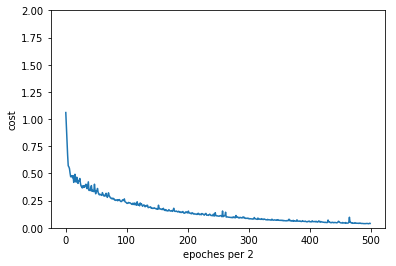

In [33]:
###Start code
parameters =model_with_minibatch(X_data,y_data, layer_dims, learning_rate=0.001,num_iter=1000, mini_batch_size=256)
###End code

### Run the below cells to save your answers


In [38]:
batchnorm.save_func1(placeholders)
batchnorm.save_func2(initialize_parameters_deep)
batchnorm.save_func3(linear_forward_prop)
batchnorm.save_func4(l_layer_forwardProp)
batchnorm.save_func5(final_cost)
batchnorm.save_func6(random_samples_minibatch)
